In [ ]:
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

In [ ]:
def unzip_data(zip_path, extract_path):

    # create a ZipFile object
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path) # extract all files to the specified directory


## Section 1 : Data Analysis

In [ ]:
def parse_text_into_data(path_of_text_matches, path_of_images):
    # Define empty list to contain all file rows
    pair_images_paths = []
    is_match = []

    # Open file
    with open(path_of_text_matches, "r") as f:
        f.readline() # check that line is readable (not reaching the end)
        # Loop over all pairs (match and mismatch)
        for line in f:
            # Get line
            line_values = line.strip().split('\t')

            # match label and images paths
            if len(line_values) == 4: #images that not have a match (until row 1100 in train / 500 in test)
                image_path1 = (f"{path_of_images}/{line_values[0]}/"f"{line_values[0]}_{line_values[1].zfill(4)}.jpg")
                image_path2 = (f"{path_of_images}/{line_values[2]}/"f"{line_values[2]}_{line_values[3].zfill(4)}.jpg")
                is_match.append(0)
            else: #images that does have a match (from row 1100 in train / 500 in test)
                image_path1 = (f"{path_of_images}/{line_values[0]}/"f"{line_values[0]}_{line_values[1].zfill(4)}.jpg")
                image_path2 = (f"{path_of_images}/{line_values[0]}/"f"{line_values[0]}_{line_values[2].zfill(4)}.jpg")
                is_match.append(1)

            # Append image paths to list
            pair_images_paths.append((image_path1, image_path2))

    # Return tuple of numpy arrays
    np_arr_is_match = np.asarray(is_match)
    np_arr_images_path = np.asarray(pair_images_paths)
    return (np_arr_images_path, np_arr_is_match)


In [ ]:
def read_image(path_of_image):
    # Read image from file
    image = tf.io.read_file(path_of_image)

    # Decode image to tensor
    image = tf.image.decode_jpeg(image, channels = 1)

    # Resize image to target shape
    image = tf.image.resize(image, (105, 105))

    # Normalize pixel values to range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

In [ ]:
#parse the text file and get the data
np_arr_images_path_train, np_arr_is_match_train = parse_text_into_data(r"C:\Users\Administrator\VsProjects\Deep_Learning\HW2\data\pairsDevTrain.txt", r"C:\Users\Administrator\VsProjects\Deep_Learning\HW2\data\lfw2\lfw2")
np_arr_images_path_test, np_arr_is_match_test = parse_text_into_data(r"C:\Users\Administrator\VsProjects\Deep_Learning\HW2\data\pairsDevTest.txt", r"C:\Users\Administrator\VsProjects\Deep_Learning\HW2\data\lfw2\lfw2")


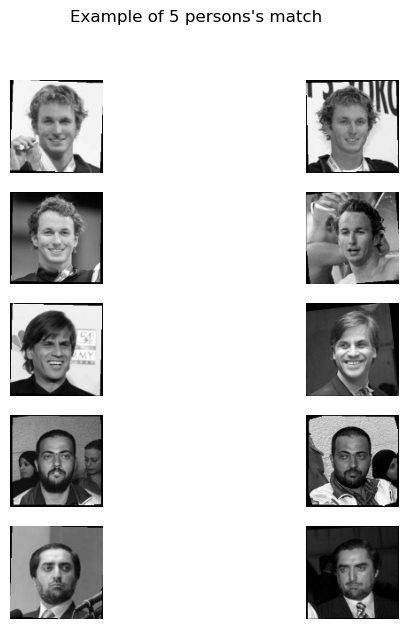

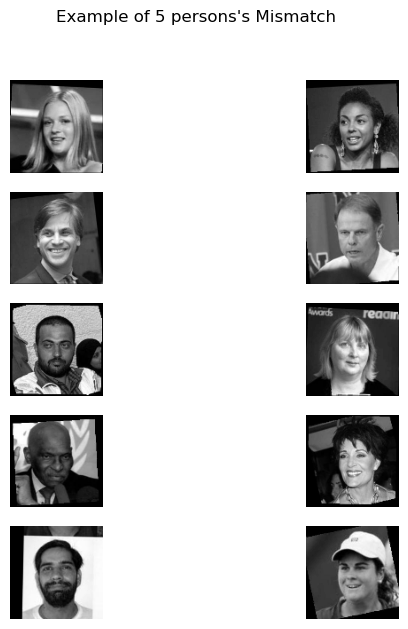

In [ ]:
# Create subplot
fig, axes = plt.subplots(5, 2, figsize=(7, 7))

for i, paths in enumerate(np_arr_images_path_train[np_arr_is_match_train == 1][:5]):
  # Plot pair images
  axes[i, 0].imshow(tf.image.convert_image_dtype(read_image(paths[0]).numpy(), "uint8"),cmap="gray")
  axes[i, 1].imshow(tf.image.convert_image_dtype(read_image(paths[1]).numpy(), "uint8"),cmap="gray")

  # Remove axis
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')

# Add title
fig.suptitle("Example of 5 persons's match")
plt.show()


# Create subplot
fig, axes = plt.subplots(5, 2, figsize=(7, 7))

for i, paths in enumerate(np_arr_images_path_train[np_arr_is_match_train == 0][:5]):
  # Plot pair images
  axes[i, 0].imshow(tf.image.convert_image_dtype(read_image(paths[0]).numpy(), "uint8"),cmap="gray")
  axes[i, 1].imshow(tf.image.convert_image_dtype(read_image(paths[1]).numpy(), "uint8"),cmap="gray")

  # Remove axis
  axes[i, 0].axis('off')
  axes[i, 1].axis('off')

# Add title
fig.suptitle("Example of 5 persons's Mismatch")
plt.show()

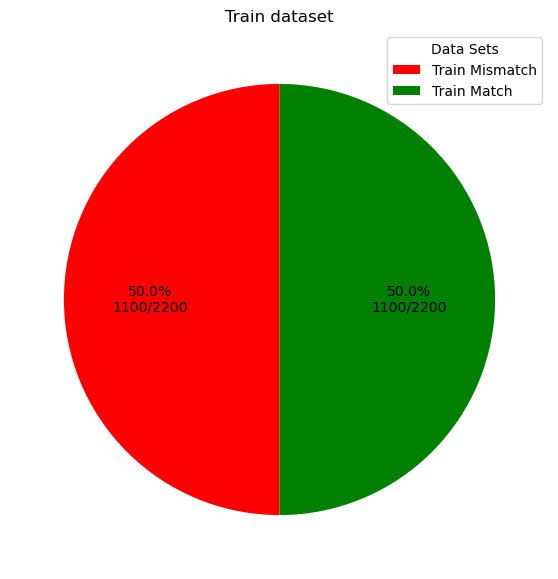

In [ ]:
# Define pie chart labels
pie_labels = ["Train Mismatch", "Train Match"]

# Calculate the number of mismatch and match pairs in train set and test set
train_mismatch = (np_arr_is_match_train == 0).sum()
train_match = (np_arr_is_match_train == 1).sum()
train_total = len(np_arr_is_match_train)

# Create data lists for train set and test set
train_data = [train_mismatch, train_match]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Create pie chart for train set
train_wedges, train_texts, train_autotexts = ax.pie(train_data, autopct=lambda pct: f"{pct:.1f}%\n{int(round(pct/100*train_total))}/{train_total}", startangle=90, colors = ["red", "green"])


# Add labels to pie wedges
for wedge, label in zip(train_wedges, pie_labels[:2]):
    wedge.set_label(f"{label}: {train_data[pie_labels.index(label)]}")


# Configure figure
ax.set_title("Train dataset")

# Add legend
ax.legend(train_wedges, pie_labels, title="Data Sets")

# Show plot
plt.show()


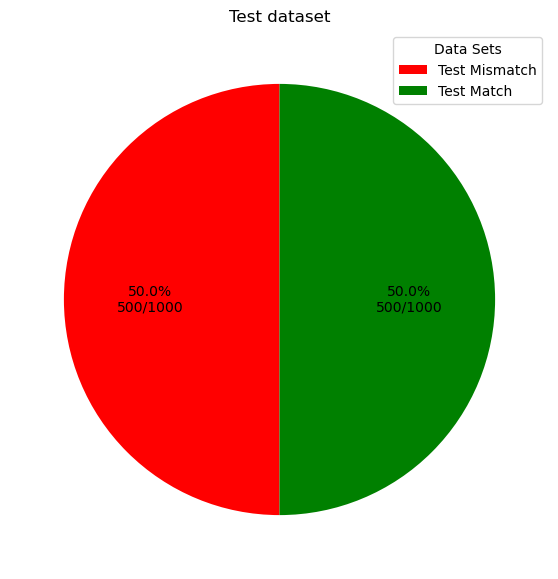

In [ ]:
# Define pie chart labels
pie_labels = ["Test Mismatch", "Test Match"]

# Calculate the number of mismatch and match pairs in train set and test set
test_mismatch = (np_arr_is_match_test == 0).sum()
test_match = (np_arr_is_match_test == 1).sum()
test_total = len(np_arr_is_match_test)

# Create data lists for train set and test set
test_data = [test_mismatch, test_match]

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

# Create pie chart for train set
test_wedges, test_texts, test_autotexts = ax.pie(test_data, autopct=lambda pct: f"{pct:.1f}%\n{int(round(pct/100*test_total))}/{test_total}", startangle=90, colors = ["red", "green"])


# Add labels to pie wedges
for wedge, label in zip(test_wedges, pie_labels[:2]):
    wedge.set_label(f"{label}: {test_data[pie_labels.index(label)]}")


# Configure figure
ax.set_title("Test dataset")

# Add legend
ax.legend(test_wedges, pie_labels, title="Data Sets")

# Show plot
plt.show()


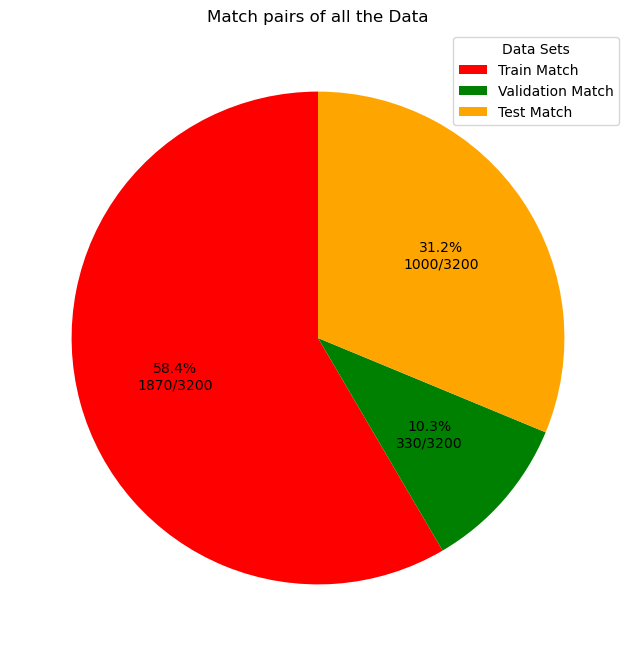

In [ ]:
# split train set to train set and validation set, use stratify to keep percentage of data
images_path_train, images_path_validation, is_match_train, is_match_validation = train_test_split(np_arr_images_path_train, np_arr_is_match_train, test_size = 0.15, random_state=42, stratify = np_arr_is_match_train)


# Define pie chart labels
pie_labels = ["Train Match", "Validation Match", "Test Match"]

# Calculate the number of mismatch and match pairs in train set and test set
train_match = (is_match_train == 1).sum()
validation_match = (is_match_validation == 1).sum()
test_match = (np_arr_is_match_test == 1).sum()


train_total = len(is_match_train)
validation_total = len(is_match_validation)
test_total = len(np_arr_is_match_test)
total = train_total + validation_total + test_total

# Create data lists for train set and test set
pie_data = [train_match, validation_match, test_match]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create pie chart for train set
wedges, texts, autotexts = ax.pie(pie_data, autopct=lambda pct: f"{pct:.1f}%\n{int(round(pct/100*total))}/{total}", startangle=90, colors = ["red", "green", "orange"])


# Add labels to pie wedges
for wedge, label in zip(wedges, pie_labels[:3]):
    wedge.set_label(f"{label}: {pie_data[pie_labels.index(label)]}")


# Configure figure
ax.set_title("Match pairs of all the Data")

# Add legend
ax.legend(wedges, pie_labels, title="Data Sets", loc = "upper right")

# Show plot
plt.show()


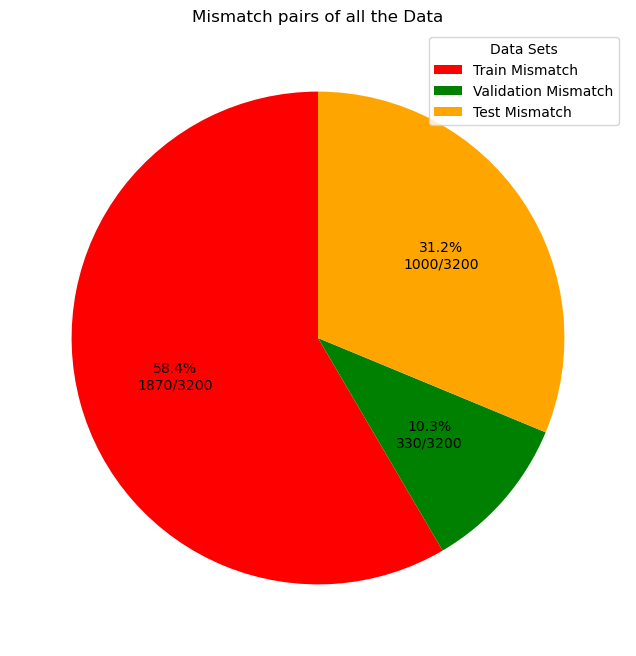

In [ ]:
# # split train set to train set and validation set, use stratify to keep percentage of data
# np_arr_images_path_train, np_arr_is_match_train = parse_text_into_data(r"C:\Users\Administrator\VsProjects\Deep_Learning\HW2\data\pairsDevTrain.txt", r"HW2\data\lfw2\lfw2")
# images_path_train, images_path_validation, is_match_train, is_match_validation = train_test_split(np_arr_images_path_train, np_arr_is_match_train, test_size = 0.1, random_state=42, stratify = np_arr_is_match_train)


# Define pie chart labels
pie_labels = ["Train Mismatch", "Validation Mismatch", "Test Mismatch"]

# Calculate the number of mismatch and match pairs in train set and test set
train_match = (is_match_train == 0).sum()
validation_match = (is_match_validation == 0).sum()
test_match = (np_arr_is_match_test == 0).sum()


train_total = len(is_match_train)
validation_total = len(is_match_validation)
test_total = len(np_arr_is_match_test)
total = train_total + validation_total + test_total

# Create data lists for train set and test set
pie_data = [train_match, validation_match, test_match]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create pie chart for train set
wedges, texts, autotexts = ax.pie(pie_data, autopct=lambda pct: f"{pct:.1f}%\n{int(round(pct/100*total))}/{total}", startangle=90, colors = ["red", "green", "orange"])


# Add labels to pie wedges
for wedge, label in zip(wedges, pie_labels[:3]):
    wedge.set_label(f"{label}: {pie_data[pie_labels.index(label)]}")


# Configure figure
ax.set_title("Mismatch pairs of all the Data")

# Add legend
ax.legend(wedges, pie_labels, title="Data Sets", loc = "upper right")

# Show plot
plt.show()


## Section 2 : Create Siamese Network

In [ ]:
class Siamese_Network(models.Model):
    def __init__(self, input_shape = (105,105,1)):
        super(Siamese_Network, self).__init__()
        # input layer
        self.input_image_1 = layers.Input(input_shape)
        self.input_image_2 = layers.Input(input_shape)

        # CNN feature extractor
        self.cnn_feature_extractor = models.Sequential([
            layers.Conv2D(64, (10, 10),
                          kernel_initializer=RandomNormal(mean=0., stddev=0.01),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                          kernel_regularizer=L2(2e-4)),
            layers.BatchNormalization(momentum=0.65),
            layers.ReLU(),
            layers.MaxPool2D(),
            layers.Conv2D(128, (7, 7),
                          kernel_initializer=RandomNormal(mean=0., stddev=0.01),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                          kernel_regularizer=L2(2e-4)),
            layers.BatchNormalization(momentum=0.65),
            layers.ReLU(),
            layers.MaxPool2D(),
            layers.Conv2D(128, (4, 4),
                          kernel_initializer=RandomNormal(mean=0., stddev=0.01),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                          kernel_regularizer=L2(2e-4)),
            layers.BatchNormalization(momentum=0.65),
            layers.ReLU(),
            layers.MaxPool2D(),
            layers.Dropout(0.5),
            layers.Conv2D(256, (4, 4),
                          kernel_initializer=RandomNormal(mean=0., stddev=0.01),
                          bias_initializer=RandomNormal(mean=0.5, stddev=0.01),
                          kernel_regularizer=L2(2e-4)),
            layers.BatchNormalization(momentum=0.65),
            layers.ReLU(),
            layers.Flatten(),
            layers.Dense(4096,
                         activation='sigmoid',
                         kernel_initializer=RandomNormal(mean=0., stddev=0.2),
                         bias_initializer=RandomNormal(mean=0.5, stddev=0.01))
        ])

        self.encoded_image_1 = self.cnn_feature_extractor(self.input_image_1)
        self.encoded_image_2 = self.cnn_feature_extractor(self.input_image_2)


        l1_distance = lambda tensor_1, tensor_2: tf.abs(tensor_1 - tensor_2)
        self.distance_layer = layers.Lambda(lambda tensors: l1_distance(tensors[0], tensors[1]))

        self.distance = self.distance_layer([self.encoded_image_1, self.encoded_image_2])

        self.prediction = layers.Dense(units=1, activation='sigmoid')(self.distance)

        self.model = models.Model(inputs=[self.input_image_1, self.input_image_2], outputs=self.prediction)




    def train_model(self, images_path_train, is_match_train, images_path_validation, is_match_validation, batch_size = 64, loss='binary_crossentropy', metric_arr=['binary_accuracy', 'AUC'], learning_rate = 0.01, optimizer = optimizers.Adam, epoch = 200):
        #create the dataset in order to get the batch size
        train_dataset = self.create_dataset(images_path_train, is_match_train, batch_size)
        validation_dataset = self.create_dataset(images_path_validation, is_match_validation,batch_size)
        curr_optimizer = optimizer(learning_rate)
        self.model.compile(loss=loss, metrics=metric_arr, optimizer = curr_optimizer)


        # Create Callback for model early stopping
        earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

        # fit the model to the data
        self.info = self.model.fit(x = train_dataset, validation_data = validation_dataset, epochs = epoch, callbacks=[earlystopping])


    def evaluate(self, train_dataset, test_dataset):
        train_eval = self.model.evaluate(train_dataset)
        test_eval = self.model.evaluate(test_dataset)
        print(f"Evaluation on Train dataset - loss: {train_eval[0]}, binary_accuracy: {train_eval[1]}, AUC: {train_eval[2]}")
        print(f"Evaluation on Test dataset - loss: {test_eval[0]}, binary_accuracy: {test_eval[1]}, AUC: {test_eval[2]}")


    def create_dataset(self, path_of_pairs_of_images, label_isMatch, batch_size = 64):
        # Create dataset for pairs and labels
        image_path_1_tensor = tf.data.Dataset.from_tensor_slices(path_of_pairs_of_images[:, 0])
        image_path_2_tensor = tf.data.Dataset.from_tensor_slices(path_of_pairs_of_images[:, 1])
        label_isMatch_tensor = tf.data.Dataset.from_tensor_slices(label_isMatch)

        dataset = tf.data.Dataset.zip((image_path_1_tensor,image_path_2_tensor,label_isMatch_tensor))

        # map the images paths to the images and keep the label_isMatch
        dataset = dataset.map(lambda image_path_1, image_path_2, label: ((read_image(image_path_1),read_image(image_path_2)), label))

        # batch size
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset


In [ ]:
def create_dataset(path_of_pairs_of_images, label_isMatch, batch_size = 64):
    # Create dataset for pairs and labels
    image_path_1_tensor = tf.data.Dataset.from_tensor_slices(path_of_pairs_of_images[:, 0])
    image_path_2_tensor = tf.data.Dataset.from_tensor_slices(path_of_pairs_of_images[:, 1])
    label_isMatch_tensor = tf.data.Dataset.from_tensor_slices(label_isMatch)

    dataset = tf.data.Dataset.zip((image_path_1_tensor,image_path_2_tensor,label_isMatch_tensor))

    # map the images paths to the images and keep the label_isMatch
    dataset = dataset.map(lambda image_path_1, image_path_2, label: ((read_image(image_path_1),read_image(image_path_2)), label))


    # batch size
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
#datasets
train_dataset = create_dataset(images_path_train, is_match_train)
validation_dataset = create_dataset(images_path_validation, is_match_validation)
test_dataset = create_dataset(np_arr_images_path_test, np_arr_is_match_test)

In [ ]:
## code for visualizing the architecture of the network
model = Siamese_Network()
model.train_model(images_path_train, is_match_train, images_path_validation, is_match_validation,optimizer=optimizers.SGD ,batch_size=32,epoch=1, learning_rate=0.0001)
model.evaluate(train_dataset, test_dataset)

plot_model(model.cnn_feature_extractor, to_file='model_2.png', show_shapes=True)
#model summary
print(model.model.summary())
#feature extractor summary
print(model.cnn_feature_extractor.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 4096)         38949952    ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

Training with parameters: {'batch_size': 8, 'epochs': 100, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
234/234 [==============================] - 147s 628ms/step - loss: 0.7522 - binary_accuracy: 0.5048 - auc: 0.5101 - val_loss: 0.7409 - val_binary_accuracy: 0.5455 - val_auc: 0.5642
Epoch 2/100
234/234 [==============================] - 150s 643ms/step - loss: 0.6967 - binary_accuracy: 0.5866 - auc: 0.6221 - val_loss: 0.7320 - val_binary_accuracy: 0.5606 - val_auc: 0.5600
Epoch 3/100
234/234 [==============================] - 150s 643ms/step - loss: 0.6328 - binary_accuracy: 0.6786 - auc: 0.7468 - val_loss: 0.7089 - val_binary_accuracy: 0.5939 - val_auc: 0.6073
Epoch 4/100
234/234 [==============================] - 150s 642ms/step - loss: 0.5319 - binary_accuracy: 0.8257 - auc: 0.9085 - val_loss: 0.7023 - val_binary_accuracy: 0.6030 - val_auc: 0.6275
Epoch 5/100
234/234 [==============================] - 150s 642ms/ste

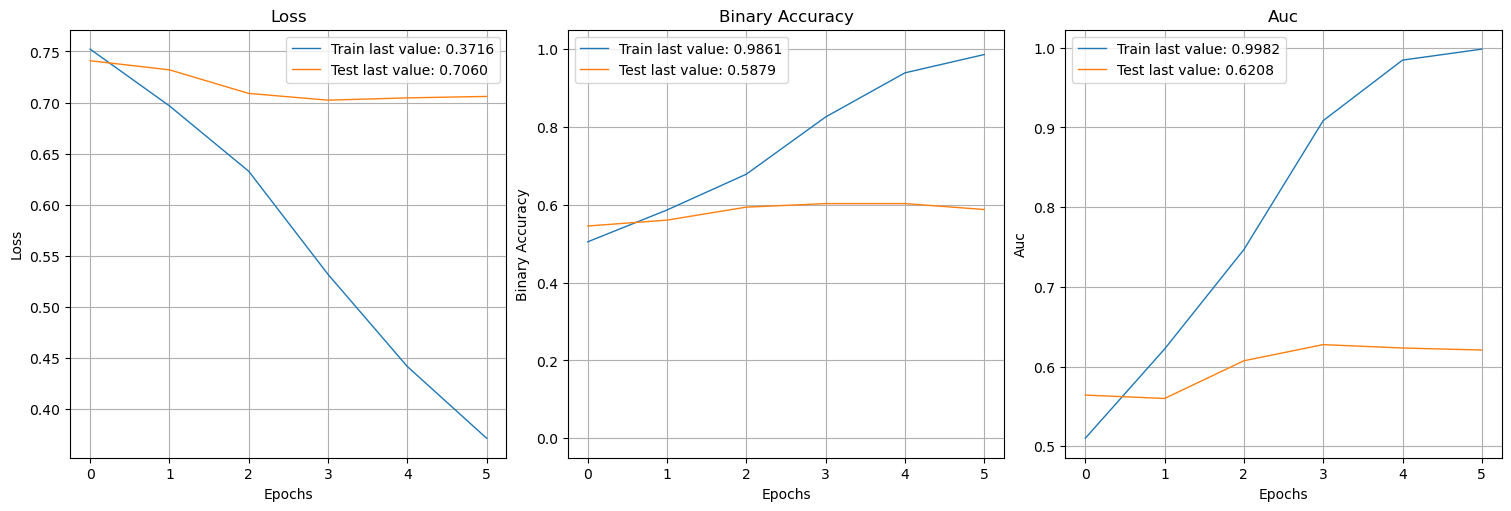

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 8, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
234/234 [==============================] - 150s 637ms/step - loss: 0.7456 - binary_accuracy: 0.5193 - auc: 0.5313 - val_loss: 0.7237 - val_binary_accuracy: 0.5424 - val_auc: 0.5898
Epoch 2/100
234/234 [==============================] - 150s 641ms/step - loss: 0.6990 - binary_accuracy: 0.5829 - auc: 0.6221 - val_loss: 0.6910 - val_binary_accuracy: 0.5758 - val_auc: 0.6435
Epoch 3/100
234/234 [==============================] - 149s 637ms/step - loss: 0.6005 - binary_accuracy: 0.7032 - auc: 0.7846 - val

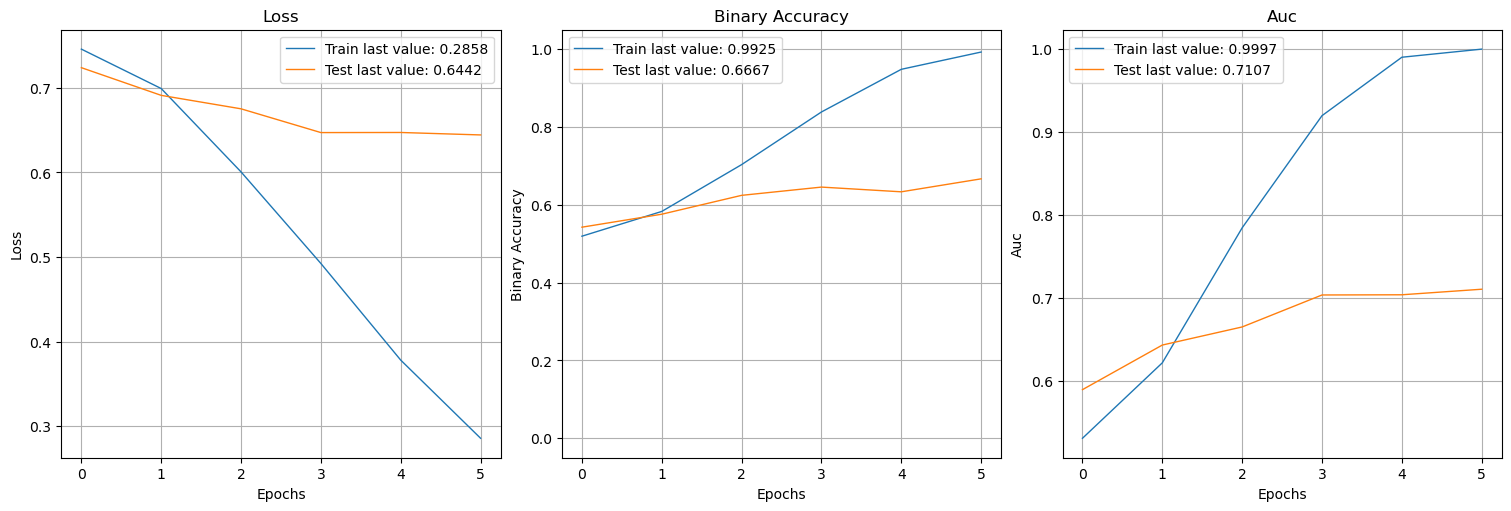

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 8, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
234/234 [==============================] - 150s 639ms/step - loss: 0.8294 - binary_accuracy: 0.5321 - auc: 0.5425 - val_loss: 0.9005 - val_binary_accuracy: 0.5273 - val_auc: 0.6319
Epoch 2/100
234/234 [==============================] - 150s 643ms/step - loss: 0.7440 - binary_accuracy: 0.5941 - auc: 0.6280 - val_loss: 0.7399 - val_binary_accuracy: 0.6121 - val_auc: 0.6587
Epoch 3/100
234/234 [==============================] - 150s 640ms/step - loss: 0.6173 - binary_accuracy: 0.6786 - auc: 0.7522 - val_

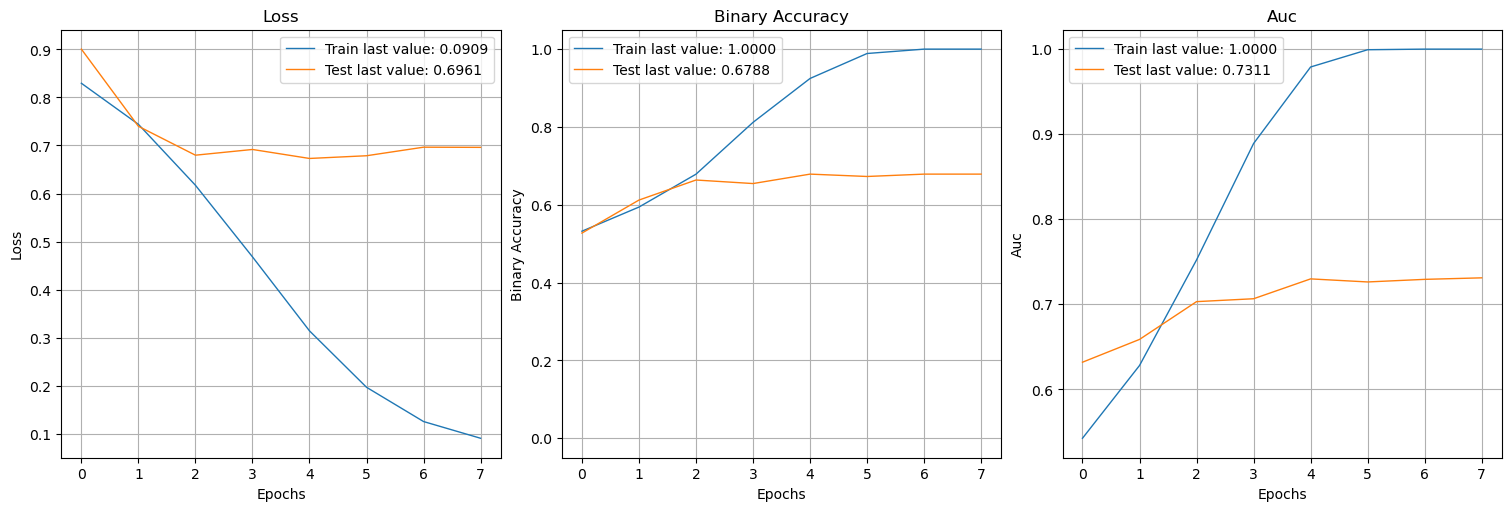

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 8, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
234/234 [==============================] - 151s 641ms/step - loss: 0.7495 - binary_accuracy: 0.5123 - auc: 0.5221 - val_loss: 0.7528 - val_binary_accuracy: 0.5091 - val_auc: 0.5152
Epoch 2/200
234/234 [==============================] - 151s 647ms/step - loss: 0.6899 - binary_accuracy: 0.5845 - auc: 0.6321 - val_loss: 0.7343 - val_binary_accuracy: 0.5152 - val_auc: 0.5348
Epoch 3/200
234/234 [==============================] - 151s 646ms/step - loss: 0.6354 - binary_accuracy: 0.6722 - auc: 0.7376 - va

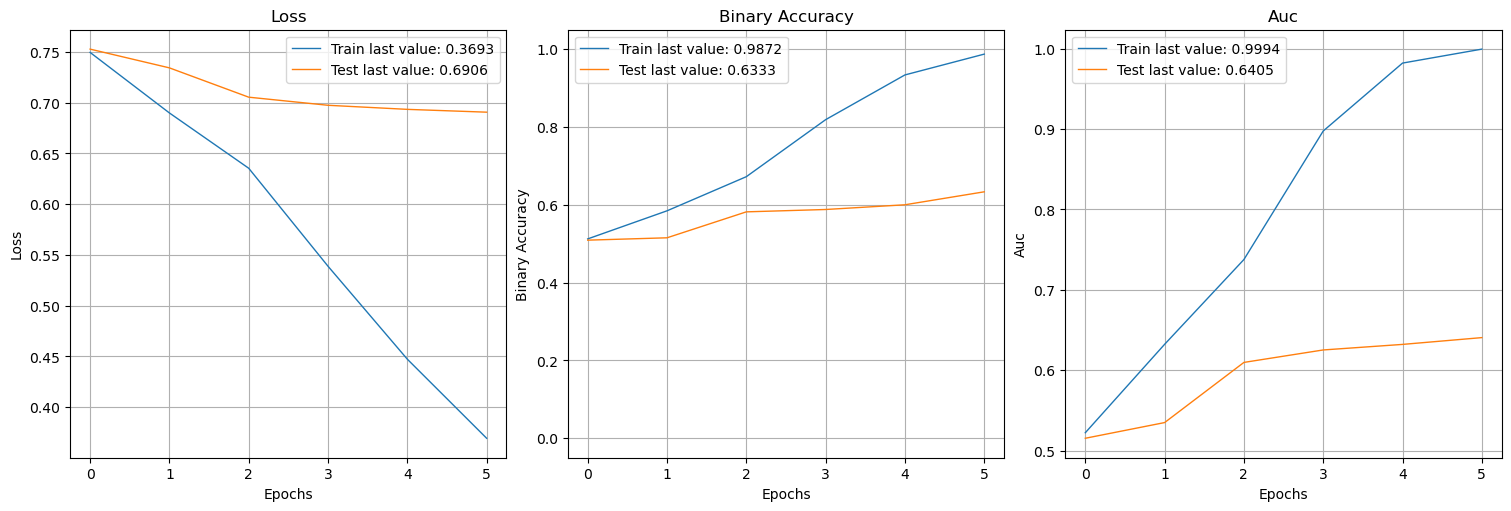

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 8, 'epochs': 200, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
234/234 [==============================] - 150s 640ms/step - loss: 0.7417 - binary_accuracy: 0.5203 - auc: 0.5404 - val_loss: 0.6984 - val_binary_accuracy: 0.5848 - val_auc: 0.6199
Epoch 2/200
234/234 [==============================] - 150s 642ms/step - loss: 0.6984 - binary_accuracy: 0.6021 - auc: 0.6292 - val_loss: 0.6850 - val_binary_accuracy: 0.6061 - val_auc: 0.6532
Epoch 3/200
234/234 [==============================] - 150s 642ms/step - loss: 0.6274 - binary_accuracy: 0.6786 - auc: 0.7458 - val

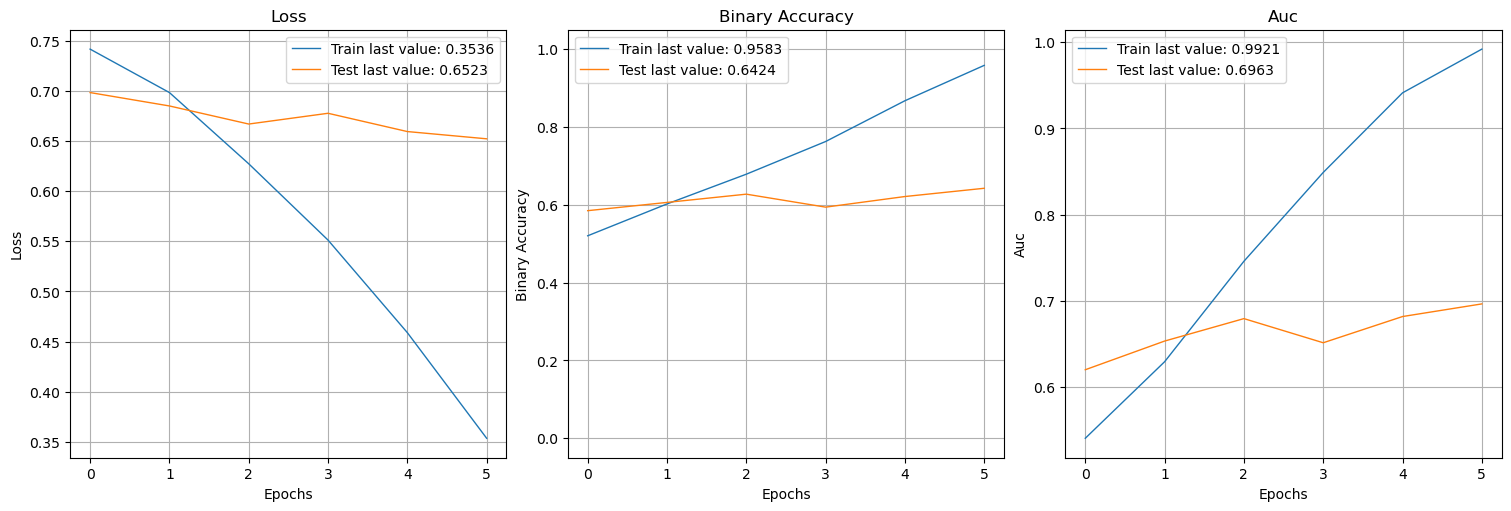

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 8, 'epochs': 200, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
234/234 [==============================] - 153s 648ms/step - loss: 0.8054 - binary_accuracy: 0.5439 - auc: 0.5676 - val_loss: 0.7154 - val_binary_accuracy: 0.5970 - val_auc: 0.6527
Epoch 2/200
234/234 [==============================] - 151s 647ms/step - loss: 0.6994 - binary_accuracy: 0.6225 - auc: 0.6750 - val_loss: 0.7121 - val_binary_accuracy: 0.6333 - val_auc: 0.6987
Epoch 3/200
234/234 [==============================] - 152s 651ms/step - loss: 0.5623 - binary_accuracy: 0.7310 - auc: 0.8051 - val_

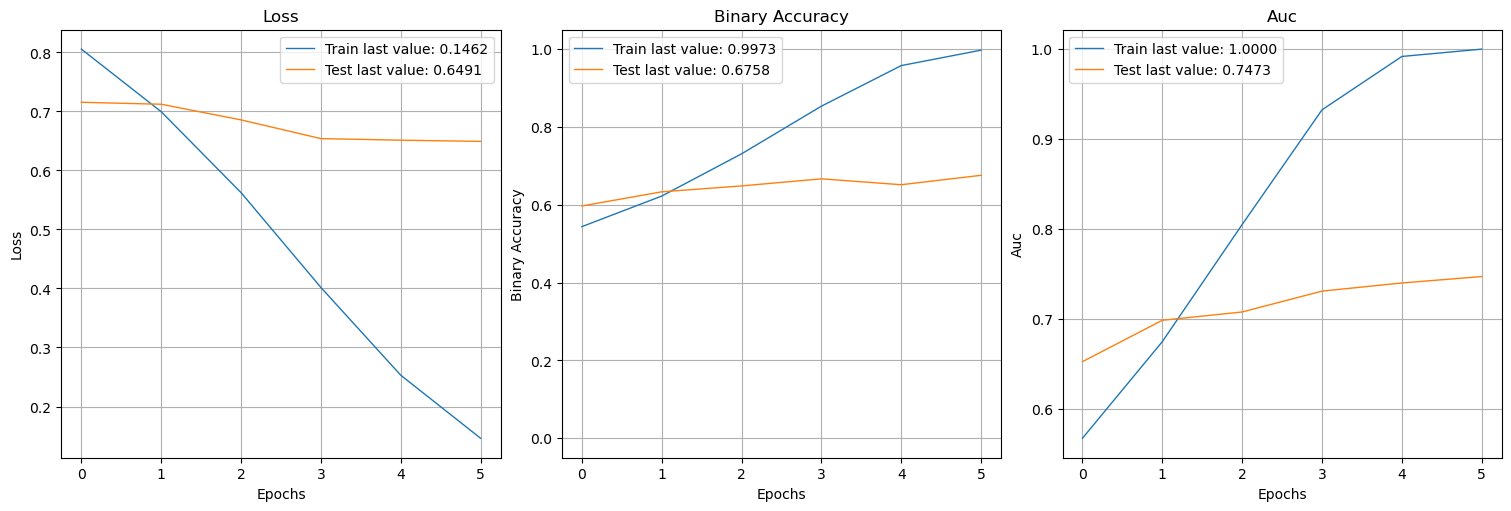

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 100, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
117/117 [==============================] - 138s 1s/step - loss: 0.7494 - binary_accuracy: 0.5005 - auc: 0.5130 - val_loss: 0.7436 - val_binary_accuracy: 0.5091 - val_auc: 0.5257
Epoch 2/100
117/117 [==============================] - 132s 1s/step - loss: 0.6899 - binary_accuracy: 0.5957 - auc: 0.6359 - val_loss: 0.7214 - val_binary_accuracy: 0.5788 - val_auc: 0.5819
Epoch 3/100
117/117 [==============================] - 132s 1s/step - loss: 0.6087 - binary_accuracy: 0.7166 - auc: 0.7926 - val_loss: 

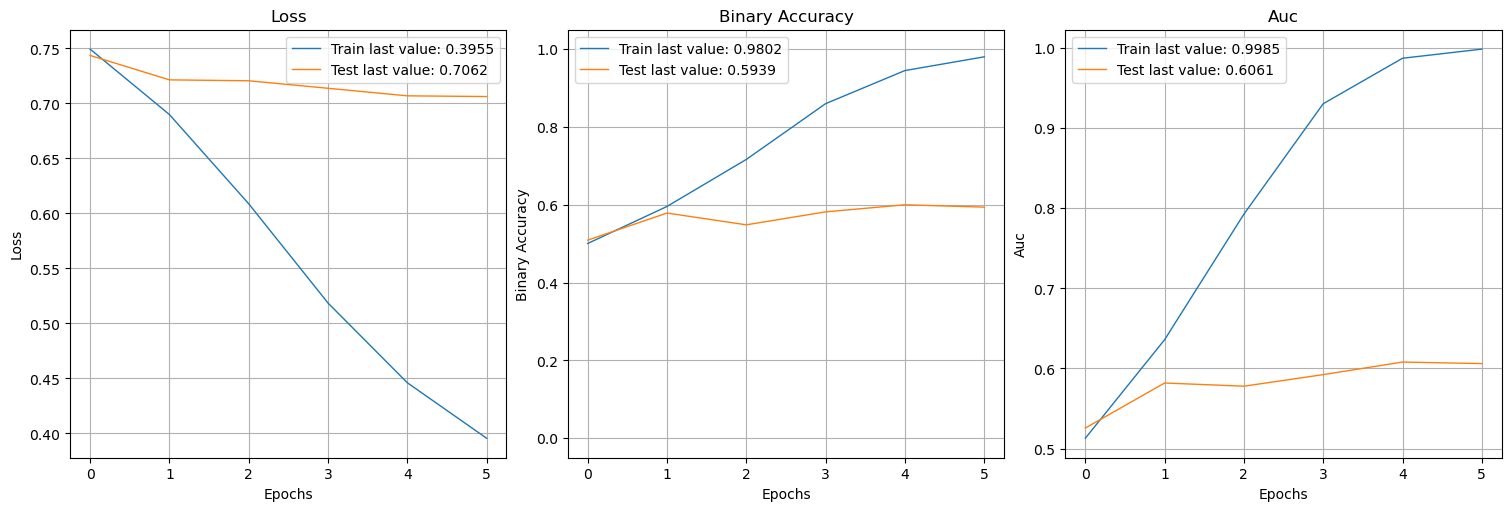

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
117/117 [==============================] - 132s 1s/step - loss: 0.7319 - binary_accuracy: 0.5380 - auc: 0.5520 - val_loss: 0.6882 - val_binary_accuracy: 0.5818 - val_auc: 0.6348
Epoch 2/100
117/117 [==============================] - 132s 1s/step - loss: 0.6795 - binary_accuracy: 0.6027 - auc: 0.6534 - val_loss: 0.6627 - val_binary_accuracy: 0.6242 - val_auc: 0.6794
Epoch 3/100
117/117 [==============================] - 131s 1s/step - loss: 0.6104 - binary_accuracy: 0.6995 - auc: 0.7729 - val_loss: 0

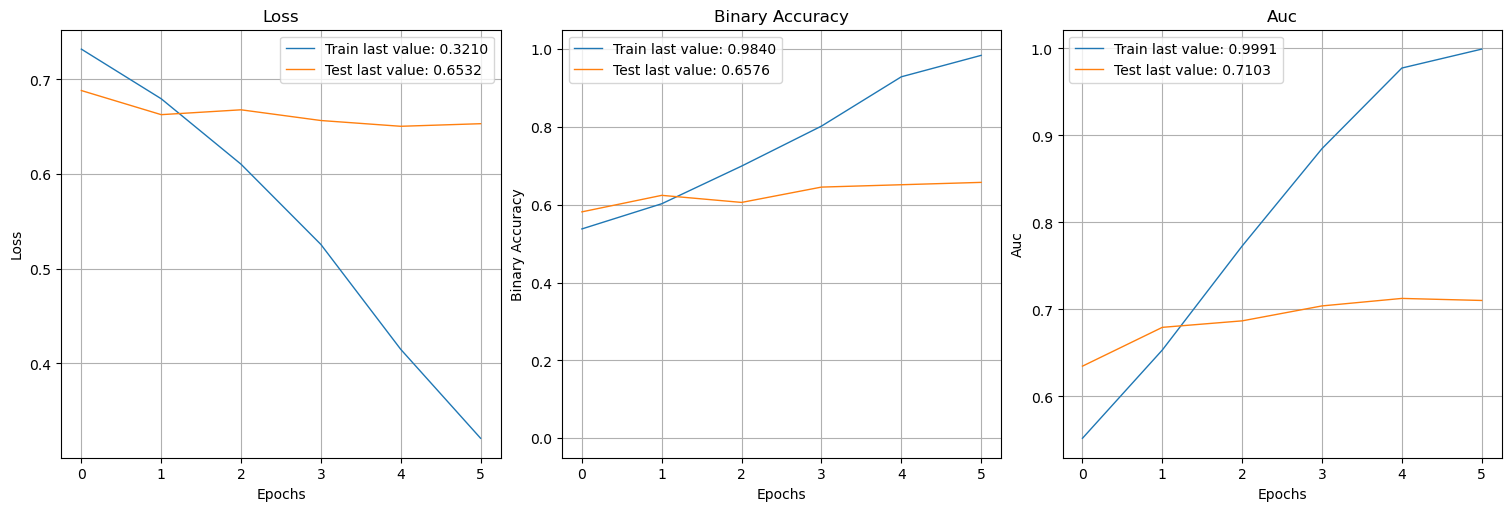

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
117/117 [==============================] - 134s 1s/step - loss: 0.7912 - binary_accuracy: 0.5385 - auc: 0.5481 - val_loss: 0.7328 - val_binary_accuracy: 0.5727 - val_auc: 0.6228
Epoch 2/100
117/117 [==============================] - 134s 1s/step - loss: 0.6849 - binary_accuracy: 0.6209 - auc: 0.6746 - val_loss: 0.6920 - val_binary_accuracy: 0.6030 - val_auc: 0.6495
Epoch 3/100
117/117 [==============================] - 133s 1s/step - loss: 0.5572 - binary_accuracy: 0.7406 - auc: 0.8162 - val_loss: 0.

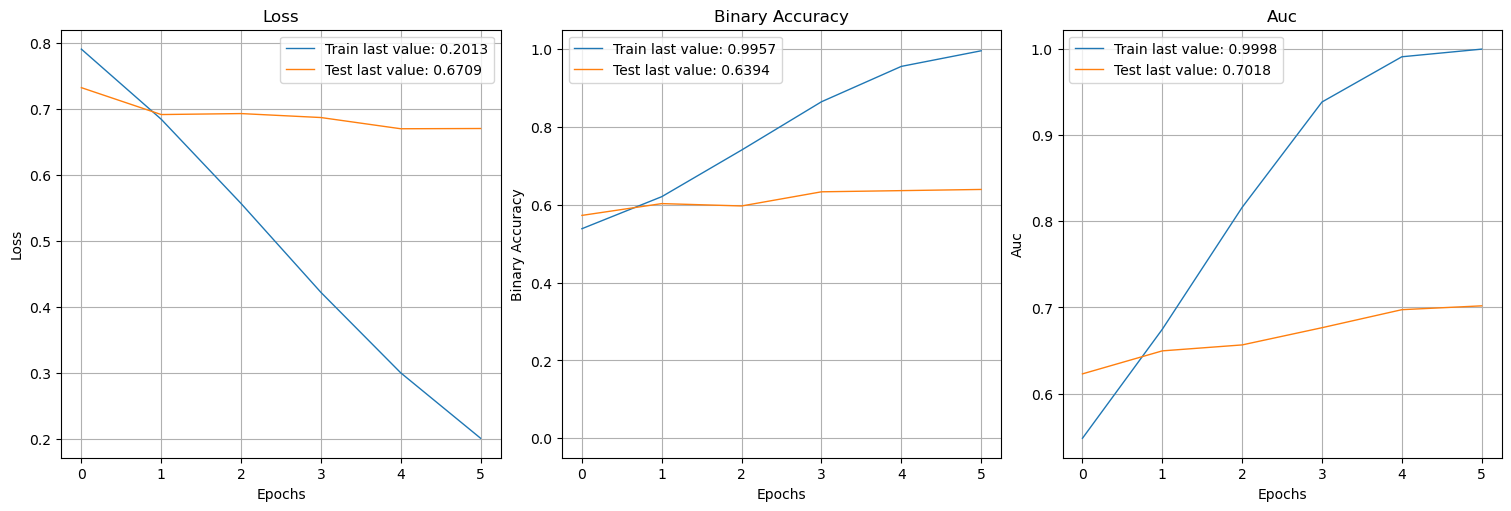

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
117/117 [==============================] - 135s 1s/step - loss: 0.7605 - binary_accuracy: 0.4973 - auc: 0.4994 - val_loss: 0.7412 - val_binary_accuracy: 0.5515 - val_auc: 0.5365
Epoch 2/200
117/117 [==============================] - 134s 1s/step - loss: 0.7067 - binary_accuracy: 0.5717 - auc: 0.6013 - val_loss: 0.7264 - val_binary_accuracy: 0.5394 - val_auc: 0.5655
Epoch 3/200
117/117 [==============================] - 135s 1s/step - loss: 0.6478 - binary_accuracy: 0.6583 - auc: 0.7183 - val_loss: 

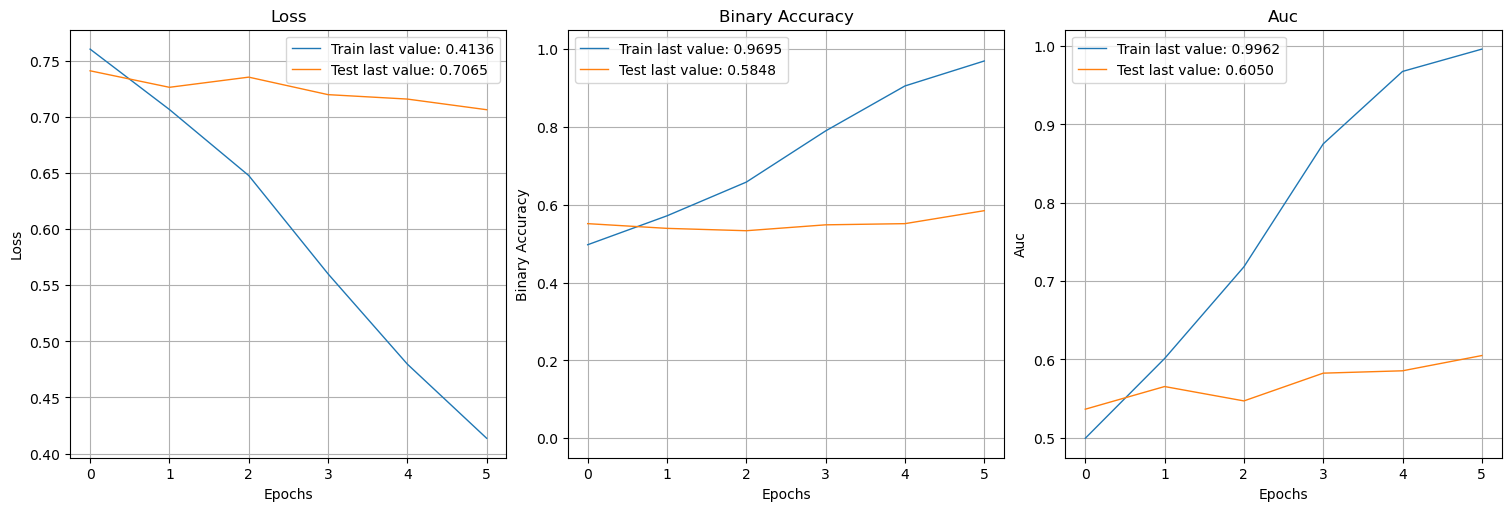

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 200, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
117/117 [==============================] - 134s 1s/step - loss: 0.7354 - binary_accuracy: 0.5364 - auc: 0.5515 - val_loss: 0.7339 - val_binary_accuracy: 0.5030 - val_auc: 0.5520
Epoch 2/200
117/117 [==============================] - 134s 1s/step - loss: 0.6669 - binary_accuracy: 0.6316 - auc: 0.6775 - val_loss: 0.6982 - val_binary_accuracy: 0.6030 - val_auc: 0.6339
Epoch 3/200
117/117 [==============================] - 134s 1s/step - loss: 0.5979 - binary_accuracy: 0.7096 - auc: 0.7857 - val_loss: 0

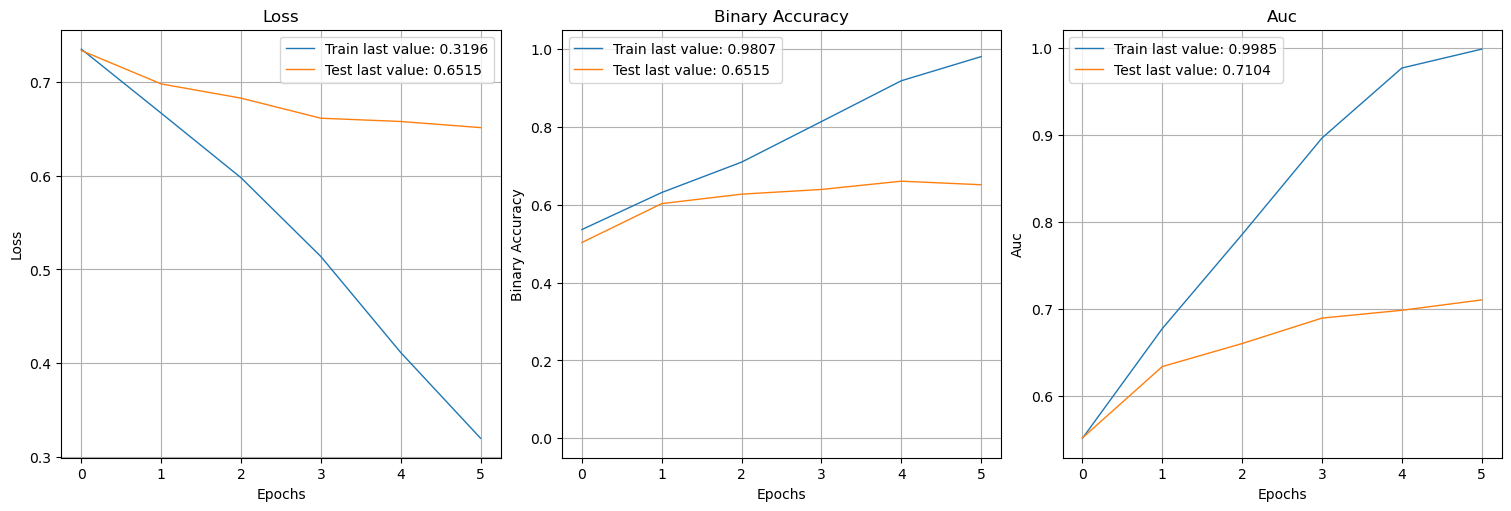

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 16, 'epochs': 200, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
117/117 [==============================] - 135s 1s/step - loss: 0.7913 - binary_accuracy: 0.5374 - auc: 0.5451 - val_loss: 0.6978 - val_binary_accuracy: 0.6303 - val_auc: 0.6442
Epoch 2/200
117/117 [==============================] - 137s 1s/step - loss: 0.7025 - binary_accuracy: 0.6043 - auc: 0.6468 - val_loss: 0.7036 - val_binary_accuracy: 0.5939 - val_auc: 0.6355
Epoch 3/200
117/117 [==============================] - 134s 1s/step - loss: 0.5713 - binary_accuracy: 0.7203 - auc: 0.8002 - val_loss: 0.

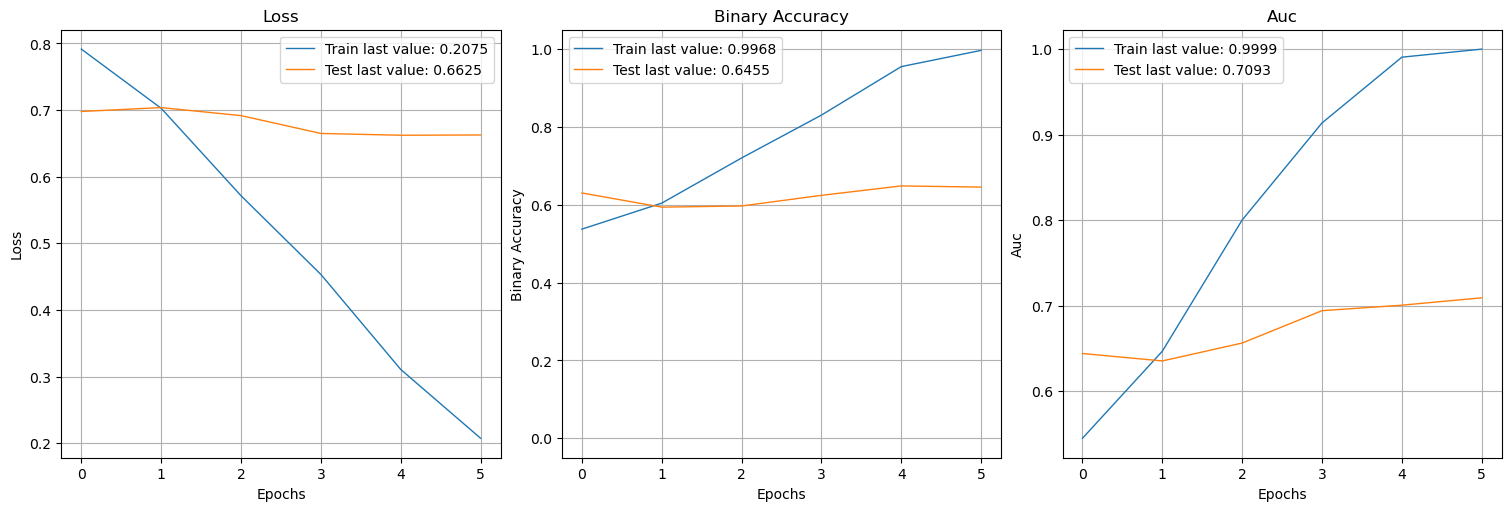

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
59/59 [==============================] - 125s 2s/step - loss: 0.7415 - binary_accuracy: 0.5150 - auc: 0.5254 - val_loss: 0.7477 - val_binary_accuracy: 0.4970 - val_auc: 0.5157
Epoch 2/100
59/59 [==============================] - 122s 2s/step - loss: 0.6725 - binary_accuracy: 0.6219 - auc: 0.6696 - val_loss: 0.7453 - val_binary_accuracy: 0.5030 - val_auc: 0.5113
Epoch 3/100
59/59 [==============================] - 122s 2s/step - loss: 0.5960 - binary_accuracy: 0.7406 - auc: 0.8259 - val_loss: 0.7359

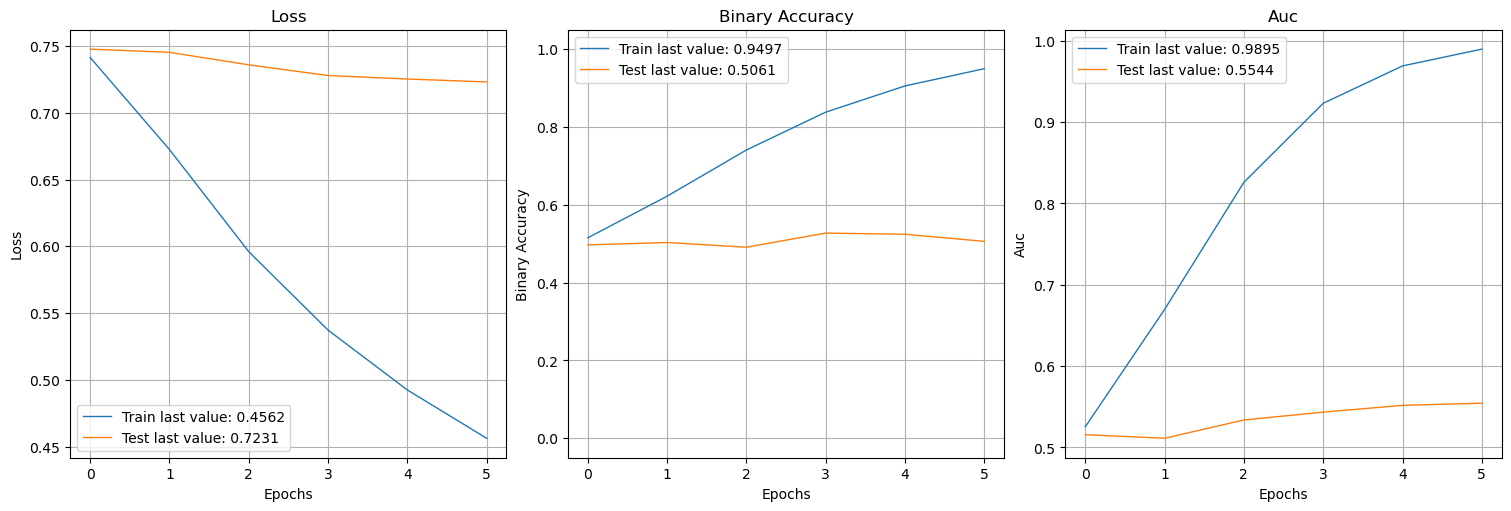

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
59/59 [==============================] - 124s 2s/step - loss: 0.7434 - binary_accuracy: 0.5262 - auc: 0.5331 - val_loss: 0.7257 - val_binary_accuracy: 0.5394 - val_auc: 0.5638
Epoch 2/100
59/59 [==============================] - 122s 2s/step - loss: 0.6931 - binary_accuracy: 0.5904 - auc: 0.6275 - val_loss: 0.7263 - val_binary_accuracy: 0.5424 - val_auc: 0.5711
Epoch 3/100
59/59 [==============================] - 131s 2s/step - loss: 0.6108 - binary_accuracy: 0.7027 - auc: 0.7792 - val_loss: 0.6789 

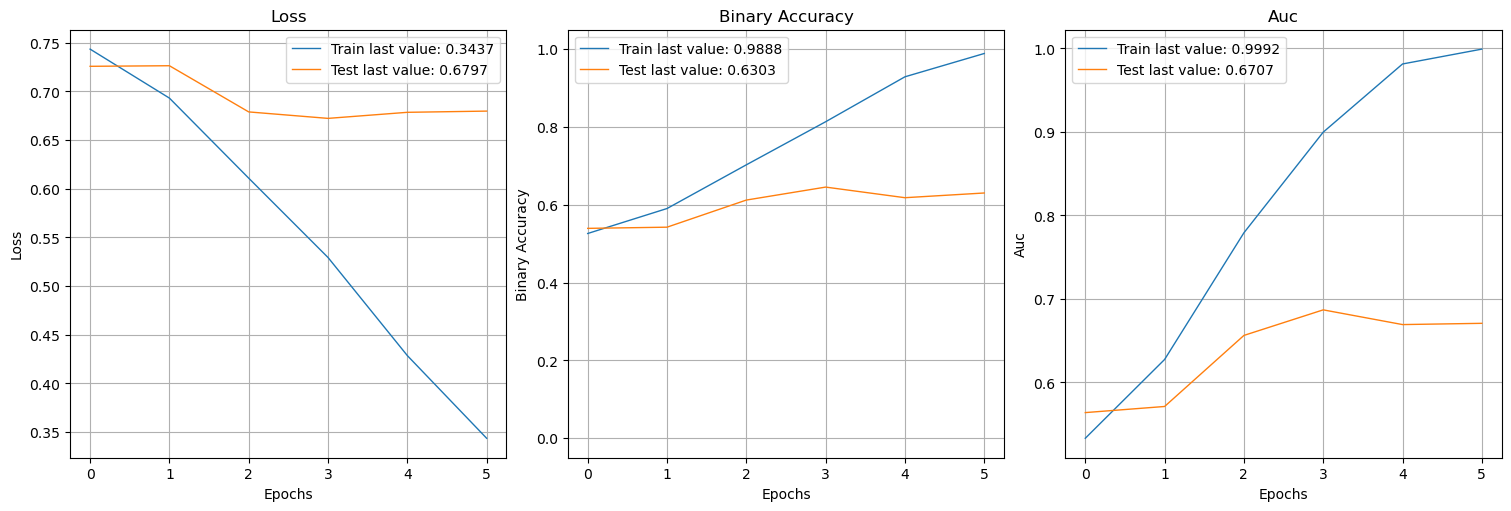

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
59/59 [==============================] - 124s 2s/step - loss: 0.7565 - binary_accuracy: 0.5299 - auc: 0.5481 - val_loss: 0.7085 - val_binary_accuracy: 0.5788 - val_auc: 0.6028
Epoch 2/100
59/59 [==============================] - 123s 2s/step - loss: 0.6804 - binary_accuracy: 0.6096 - auc: 0.6592 - val_loss: 0.7054 - val_binary_accuracy: 0.5818 - val_auc: 0.6273
Epoch 3/100
59/59 [==============================] - 126s 2s/step - loss: 0.5810 - binary_accuracy: 0.7225 - auc: 0.7994 - val_loss: 0.6810 -

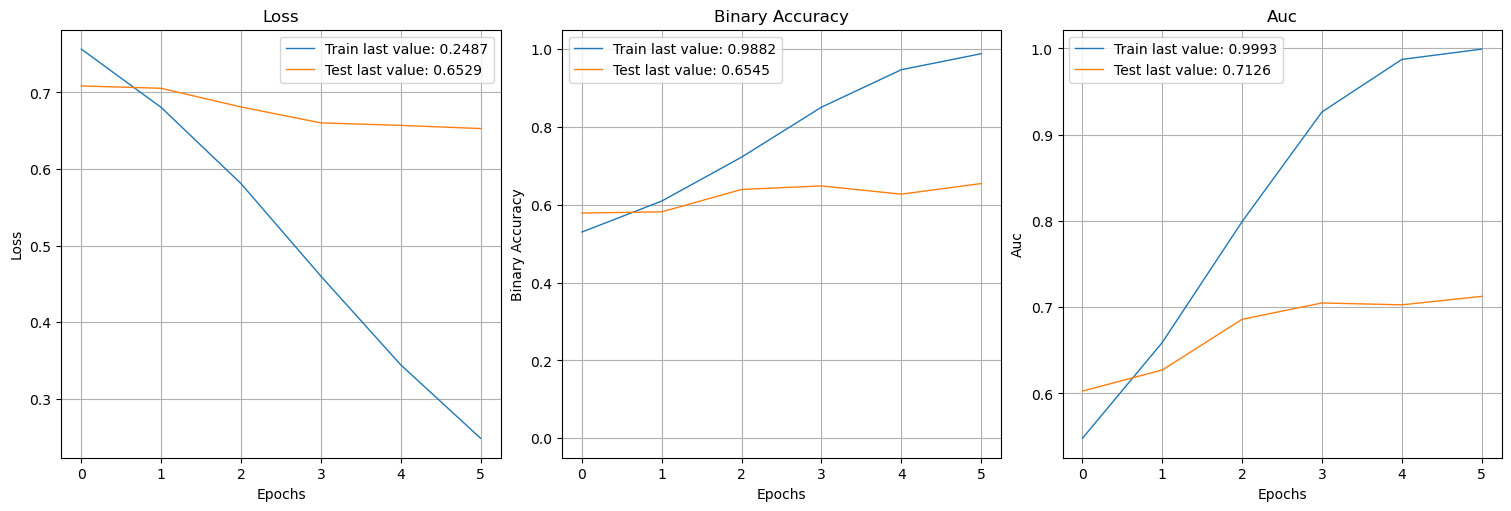

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
59/59 [==============================] - 133s 2s/step - loss: 0.7708 - binary_accuracy: 0.4925 - auc: 0.4867 - val_loss: 0.7443 - val_binary_accuracy: 0.4879 - val_auc: 0.5171
Epoch 2/200
59/59 [==============================] - 123s 2s/step - loss: 0.6793 - binary_accuracy: 0.6027 - auc: 0.6534 - val_loss: 0.7397 - val_binary_accuracy: 0.5121 - val_auc: 0.5291
Epoch 3/200
59/59 [==============================] - 131s 2s/step - loss: 0.5991 - binary_accuracy: 0.7337 - auc: 0.8207 - val_loss: 0.7279

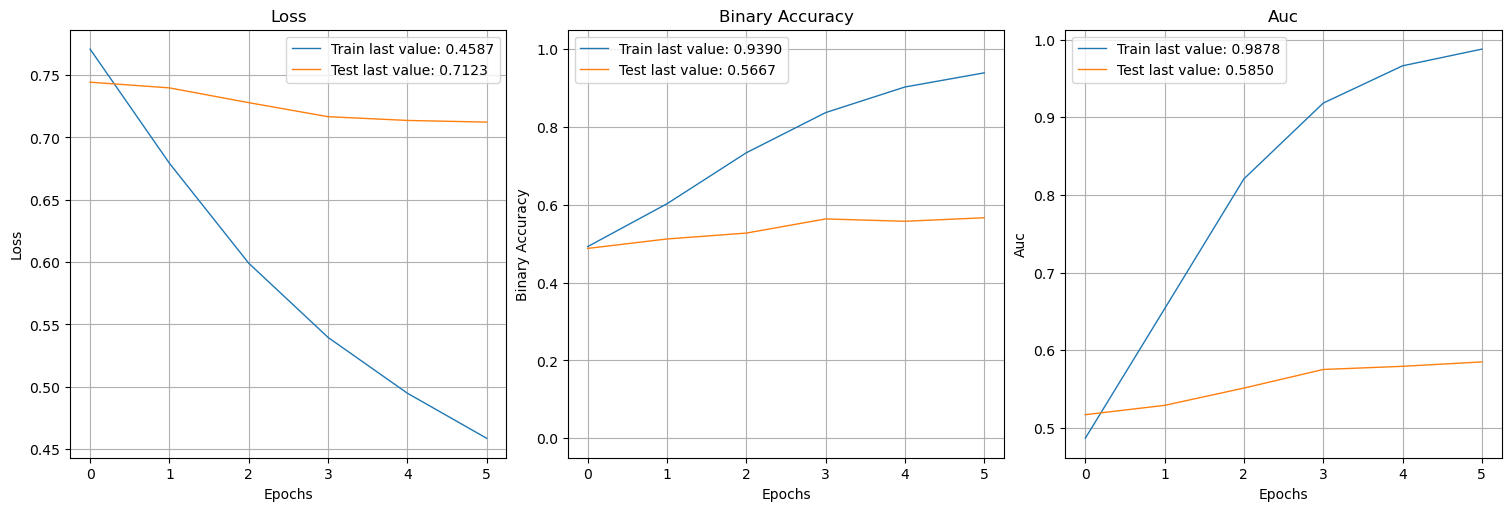

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 200, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
59/59 [==============================] - 123s 2s/step - loss: 0.7426 - binary_accuracy: 0.5209 - auc: 0.5326 - val_loss: 0.7847 - val_binary_accuracy: 0.4727 - val_auc: 0.4739
Epoch 2/200
59/59 [==============================] - 131s 2s/step - loss: 0.6959 - binary_accuracy: 0.5909 - auc: 0.6243 - val_loss: 0.7471 - val_binary_accuracy: 0.5000 - val_auc: 0.5247
Epoch 3/200
59/59 [==============================] - 130s 2s/step - loss: 0.6263 - binary_accuracy: 0.6733 - auc: 0.7499 - val_loss: 0.7290 

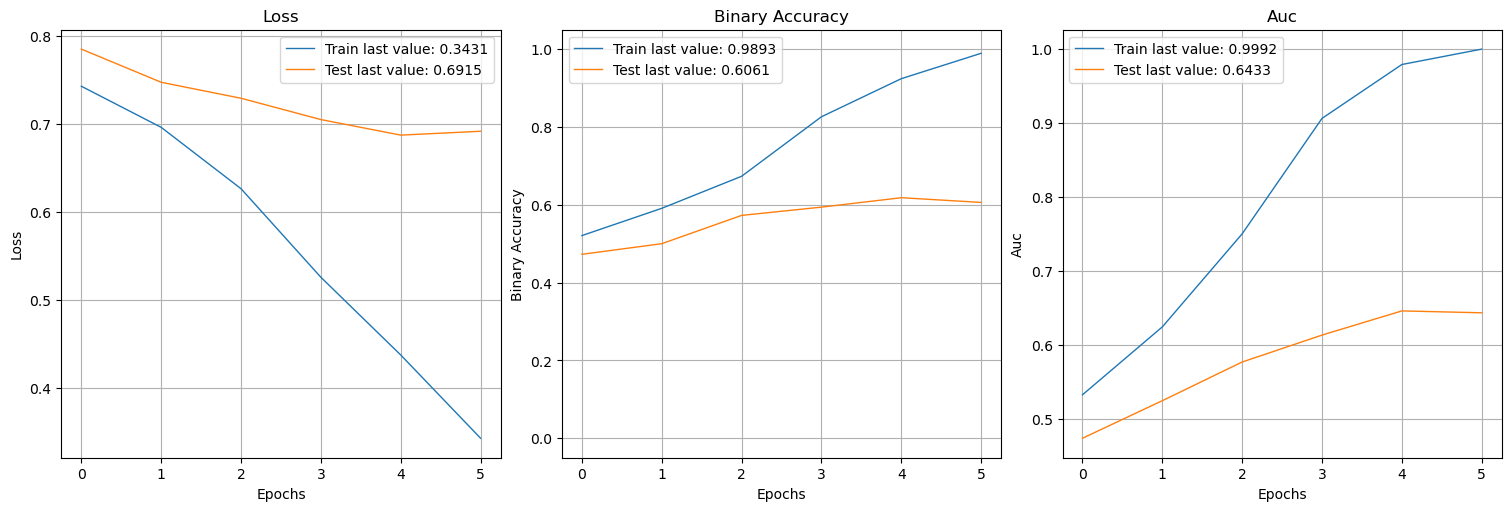

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
Training with parameters: {'batch_size': 32, 'epochs': 200, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/200
59/59 [==============================] - 125s 2s/step - loss: 0.7443 - binary_accuracy: 0.5540 - auc: 0.5712 - val_loss: 0.6950 - val_binary_accuracy: 0.6061 - val_auc: 0.6413
Epoch 2/200
59/59 [==============================] - 132s 2s/step - loss: 0.6668 - binary_accuracy: 0.6171 - auc: 0.6762 - val_loss: 0.6880 - val_binary_accuracy: 0.6091 - val_auc: 0.6512
Epoch 3/200
59/59 [==============================] - 123s 2s/step - loss: 0.5694 - binary_accuracy: 0.7299 - auc: 0.8129 - val_loss: 0.6898 -

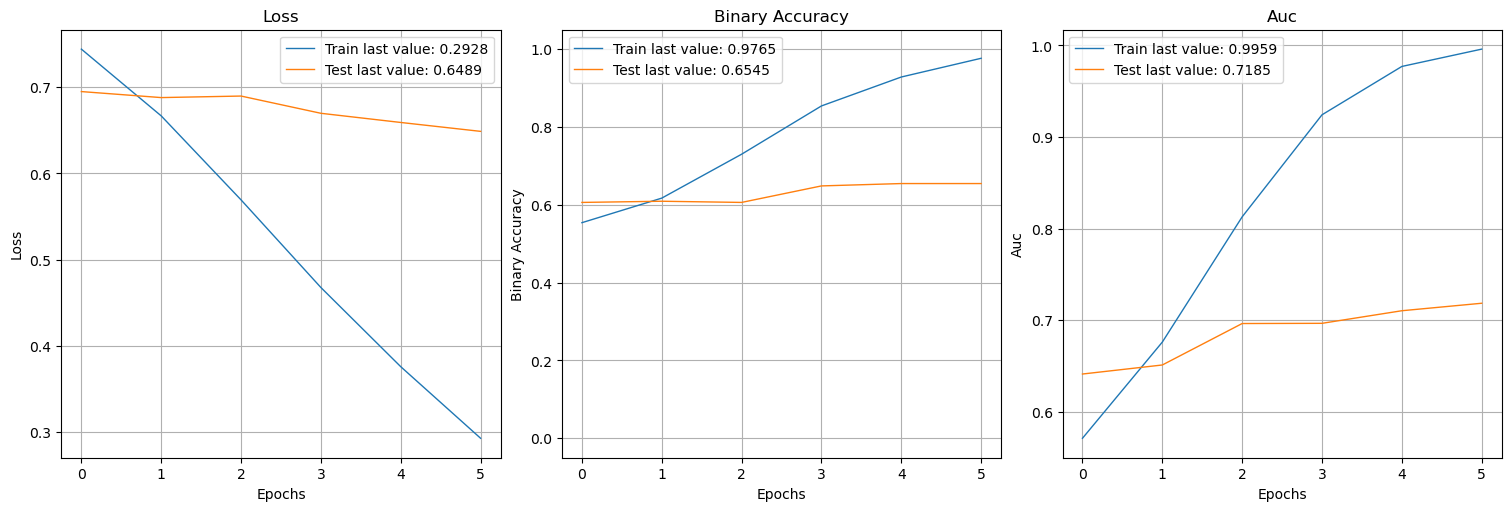

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
from sklearn.model_selection import ParameterGrid

parameters = {'epochs': [100, 200],
              'learning_rate': [0.0001, 0.001, 0.01],
              'optimizer': [optimizers.Adam, optimizers.SGD],
              'batch_size': [8,16,32]
              }

# Create a list of all parameter combinations
param_grid = ParameterGrid(parameters)

for params in param_grid:
    print(f"Training with parameters: {params}")

    # Create a new instance of the Siamese_Network class
    siamese = Siamese_Network()

    # #start time
    start = time.time()

    # Train the model using the current parameter combination
    siamese.train_model(images_path_train, is_match_train, images_path_validation, is_match_validation,
                        batch_size=params['batch_size'], learning_rate=params['learning_rate'],
                        optimizer=params['optimizer'], epoch=params['epochs'])


    name = '____'.join(['{}_:_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name + ".png"



    #end time
    end = time.time()
    print(f"The running time is {round((end-start)/60,2)} minutes.")




    # Evaluate the model on the training and validation sets
    siamese.evaluate(train_dataset, test_dataset)


    #show the stats of the running
    show_history(siamese.info.history)
    name = '____'.join(['{}_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name.replace(".", "") + ".png"
    plot_history(siamese.info.history, path=name)
    plt.close()

    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")



Training with parameters: {'batch_size': 8, 'epochs': 100, 'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>}
Epoch 1/100
234/234 [==============================] - 164s 700ms/step - loss: 0.8411 - binary_accuracy: 0.5358 - auc: 0.5358 - val_loss: 0.8043 - val_binary_accuracy: 0.5515 - val_auc: 0.6171
Epoch 2/100
234/234 [==============================] - 182s 780ms/step - loss: 0.7462 - binary_accuracy: 0.5872 - auc: 0.6208 - val_loss: 0.8545 - val_binary_accuracy: 0.5636 - val_auc: 0.6601
Epoch 3/100
234/234 [==============================] - 154s 658ms/step - loss: 0.5985 - binary_accuracy: 0.6984 - auc: 0.7713 - val_loss: 0.7349 - val_binary_accuracy: 0.6273 - val_auc: 0.7011
Epoch 4/100
234/234 [==============================] - 154s 656ms/step - loss: 0.4548 - binary_accuracy: 0.8209 - auc: 0.8980 - val_loss: 0.6589 - val_binary_accuracy: 0.6515 - val_auc: 0.7223
Epoch 5/100
234/234 [==============================] - 155s 660ms/step 

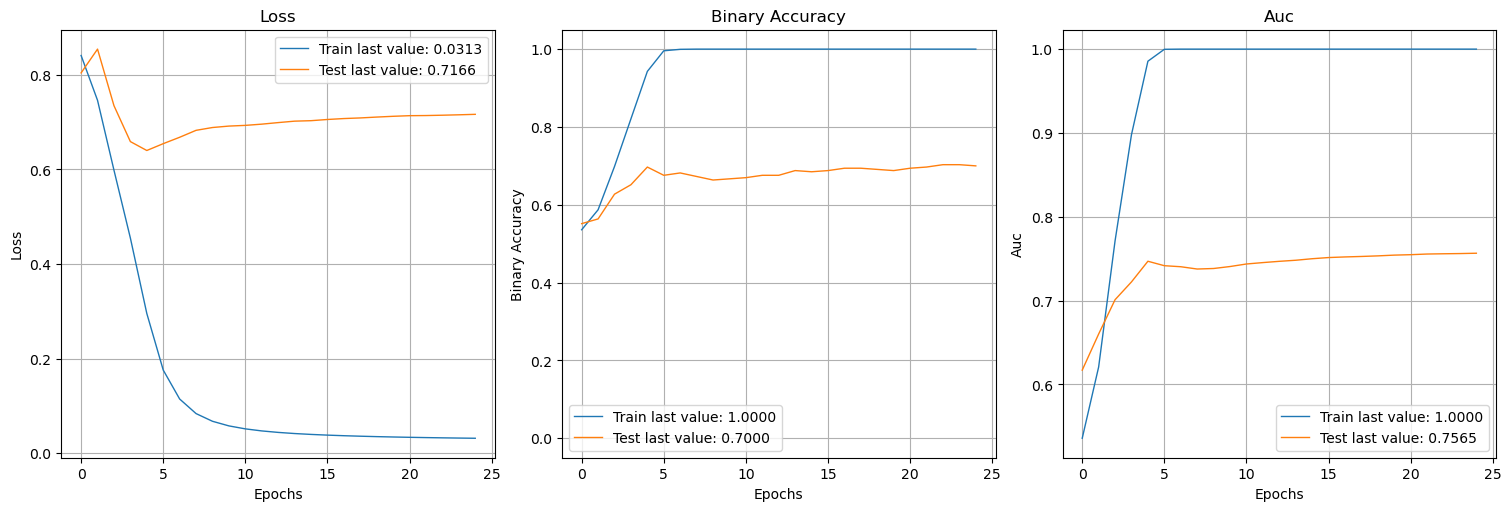

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
#Final model 1
from sklearn.model_selection import ParameterGrid

parameters = {'epochs': [100],
              'learning_rate': [0.01],
              'optimizer': [optimizers.SGD],
              'batch_size': [8]
              }

# Create a list of all parameter combinations
param_grid = ParameterGrid(parameters)

for params in param_grid:
    print(f"Training with parameters: {params}")

    # Create a new instance of the Siamese_Network class
    siamese = Siamese_Network()

    # #start time
    start = time.time()

    # Train the model using the current parameter combination
    siamese.train_model(images_path_train, is_match_train, images_path_validation, is_match_validation,
                        batch_size=params['batch_size'], learning_rate=params['learning_rate'],
                        optimizer=params['optimizer'], epoch=params['epochs'])


    name = '____'.join(['{}_:_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name + ".png"



    #end time
    end = time.time()
    print(f"The running time is {round((end-start)/60,2)} minutes.")




    # Evaluate the model on the training and validation sets
    siamese.evaluate(train_dataset, test_dataset)


    #show the stats of the running
    show_history(siamese.info.history)
    name = '____'.join(['{}_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name.replace(".", "") + ".png"
    plot_history(siamese.info.history, path=name)
    plt.close()

    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")



Training with parameters: {'batch_size': 8, 'epochs': 100, 'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>}
Epoch 1/100
234/234 [==============================] - 162s 687ms/step - loss: 0.7521 - binary_accuracy: 0.5310 - auc: 0.5319 - val_loss: 0.6979 - val_binary_accuracy: 0.5818 - val_auc: 0.6198
Epoch 2/100
234/234 [==============================] - 167s 715ms/step - loss: 0.7146 - binary_accuracy: 0.5738 - auc: 0.5990 - val_loss: 0.6750 - val_binary_accuracy: 0.6212 - val_auc: 0.6746
Epoch 3/100
234/234 [==============================] - 168s 717ms/step - loss: 0.6895 - binary_accuracy: 0.6005 - auc: 0.6427 - val_loss: 0.6548 - val_binary_accuracy: 0.6485 - val_auc: 0.7076
Epoch 4/100
234/234 [==============================] - 167s 714ms/step - loss: 0.6501 - binary_accuracy: 0.6310 - auc: 0.6991 - val_loss: 0.6625 - val_binary_accuracy: 0.6515 - val_auc: 0.7018
Epoch 5/100
234/234 [==============================] - 165s 706ms/step - loss: 0

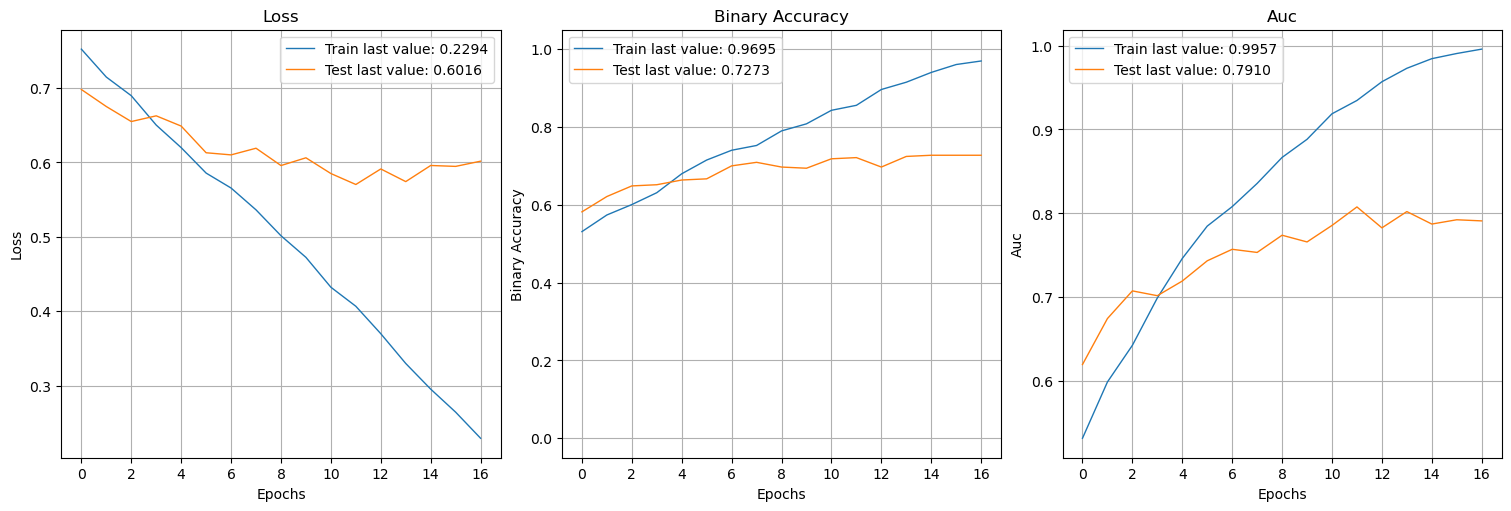

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
#Final model 3 - With dropout added
from sklearn.model_selection import ParameterGrid

parameters = {'epochs': [100],
              'learning_rate': [0.0001],
              'optimizer': [optimizers.Adam],
              'batch_size': [8]
              }

# Create a list of all parameter combinations
param_grid = ParameterGrid(parameters)

for params in param_grid:
    print(f"Training with parameters: {params}")

    # Create a new instance of the Siamese_Network class
    siamese = Siamese_Network()

    # #start time
    start = time.time()

    # Train the model using the current parameter combination
    siamese.train_model(images_path_train, is_match_train, images_path_validation, is_match_validation,
                        batch_size=params['batch_size'], learning_rate=params['learning_rate'],
                        optimizer=params['optimizer'], epoch=params['epochs'])


    name = '____'.join(['{}_:_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name + ".png"



    #end time
    end = time.time()
    print(f"The running time is {round((end-start)/60,2)} minutes.")




    # Evaluate the model on the training and validation sets
    siamese.evaluate(train_dataset, test_dataset)


    #show the stats of the running
    show_history(siamese.info.history)
    name = '____'.join(['{}_{}'.format(k, v) for k, v in list(params.items())[:3]])
    name = name.replace(".", "") + ".png"
    plot_history(siamese.info.history, path=name)
    plt.close()

    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")
    print("----------------------------------------------------------------")



## Section 3 : Analysis of the model 3 with dropout

In [ ]:
y_pred = siamese.model.predict(test_dataset)


16/16 [==============================] - 13s 779ms/step


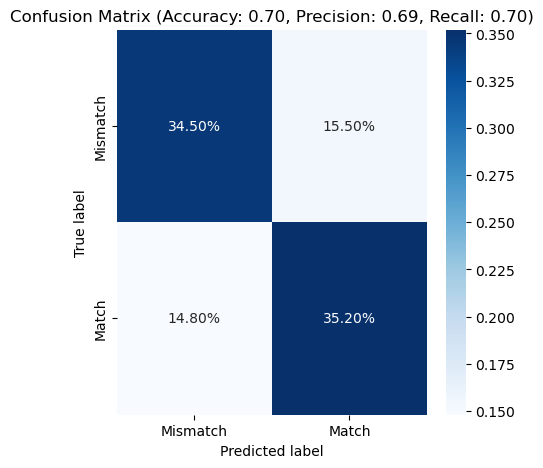

In [ ]:
#y_pred = siamese.model.predict(test_dataset)
y_pred = [1 if item > 0.5 else 0 for sublist in y_pred for item in sublist]
y_true = np_arr_is_match_test
labels = ["Mismatch", "Match"]

cm = confusion_matrix(y_true, y_pred, normalize='all')
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(5,5))
hm = sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues")
hm.set_xticklabels(labels)
hm.set_yticklabels(labels)
plt.title("Confusion Matrix (Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f})".format(accuracy, precision, recall))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [ ]:
def results_visual_on_dataset(num_of_pairs, dataset, model, is_match_list):
    y_pred = model.model.predict(dataset).squeeze()
    # match and mismatch samples
    X_pred_match = np.where(is_match_list == 1)[0]
    X_pred_mismatch = np.where(is_match_list == 0)[0]
    # match and mismatch samples predictions
    y_pred_match = np.argsort(y_pred[X_pred_match])
    y_pred_mismatch = np.argsort(y_pred[X_pred_mismatch])
    # Top correct predicted match and mismatch
    top_correct_y_pred_match = X_pred_match[y_pred_match[-num_of_pairs:]]
    top_correct_y_pred_mismatch = X_pred_mismatch[y_pred_mismatch[:num_of_pairs]]
    # Top incorrect predicted match and mismatch
    top_wrong_y_pred_match = X_pred_match[y_pred_match[:num_of_pairs]]
    top_wrong_y_pred_mismatch = X_pred_mismatch[y_pred_mismatch[-num_of_pairs:]]

    results = [top_correct_y_pred_match, top_correct_y_pred_mismatch, top_wrong_y_pred_match, top_wrong_y_pred_mismatch]
    titles = ['Top True-Positive pairs', 'Top False-Negative pairs', 'Top True-Negative pairs', 'Top False-Positive pairs']
    for i in range(4):
        fig, ax = plt.subplots(nrows=num_of_pairs, ncols=3, figsize=(10, 10))
        fig.subplots_adjust(hspace=0.5)
        c=0
        for j in reversed(range(num_of_pairs)):
            index_of_pair = results[i][j]
            ax[c, 0].imshow(tf.image.convert_image_dtype(read_image(np_arr_images_path_test[index_of_pair][0]).numpy().squeeze(-1), "uint8"),cmap="gray")
            ax[c, 2].imshow(tf.image.convert_image_dtype(read_image(np_arr_images_path_test[index_of_pair][1]).numpy().squeeze(-1), "uint8"),cmap="gray")
            prob = y_pred[index_of_pair]
            prob*=100
            prob = round(prob, 2)
            ax[c, 1].set_title(f"Same person with the probablity of {prob}%", loc='center')
            ax[c, 0].axis('off')
            ax[c, 1].axis('off')
            ax[c, 2].axis('off')
            c+=1
        plt.suptitle(titles[i], fontsize=14)
        fig.subplots_adjust(top=0.9)

16/16 [==============================] - 12s 769ms/step


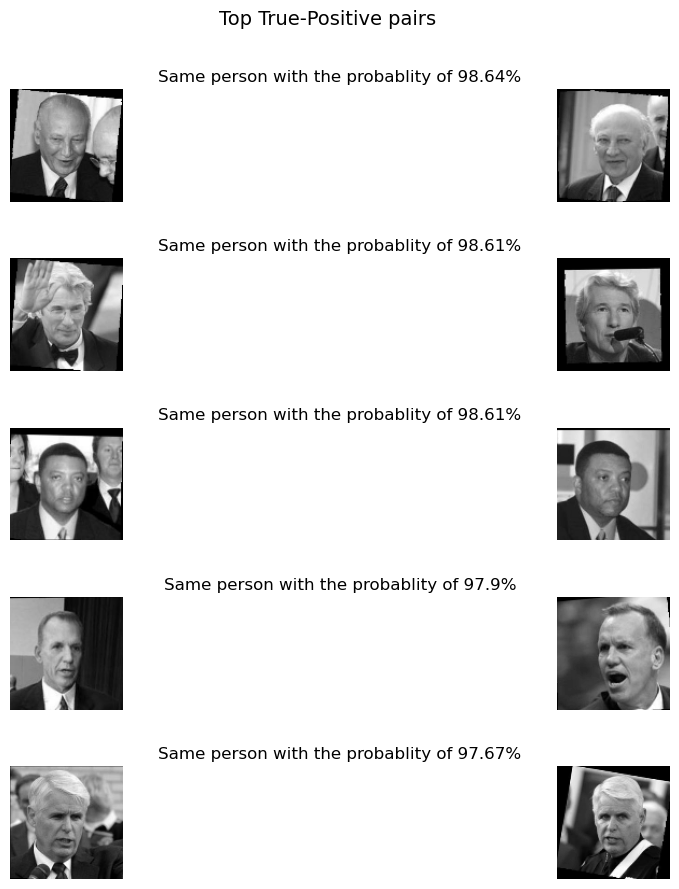

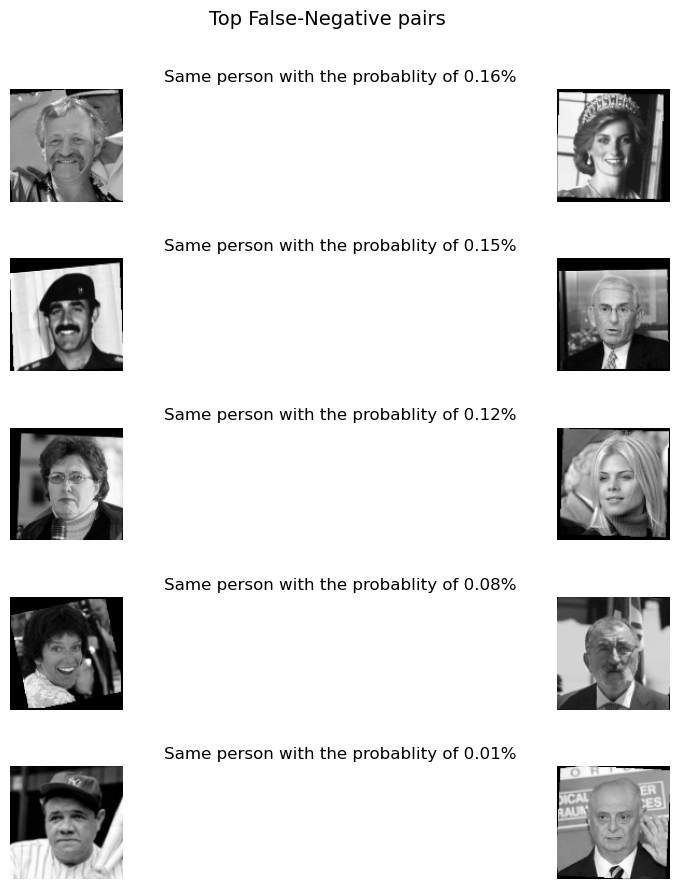

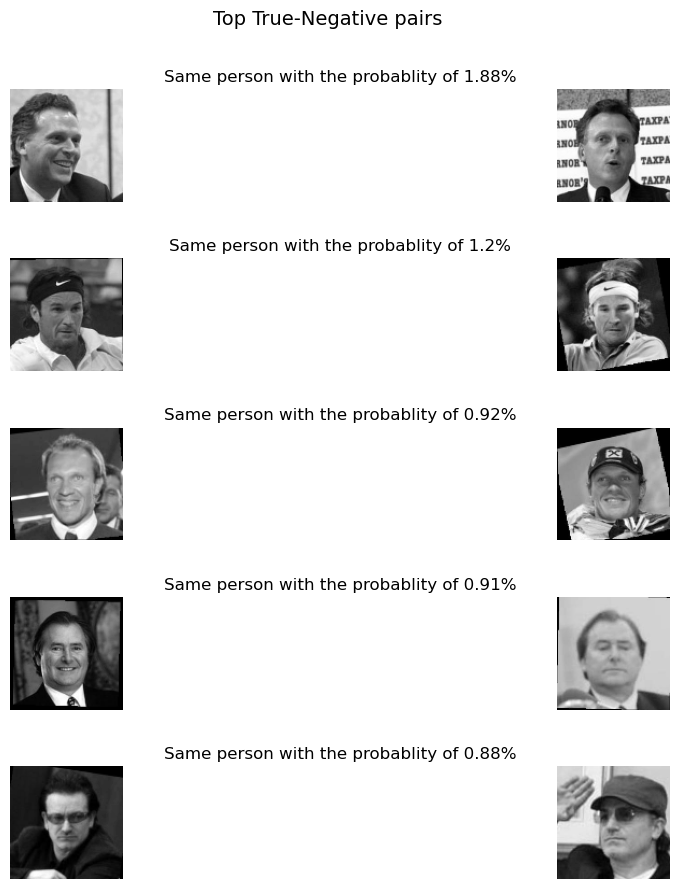

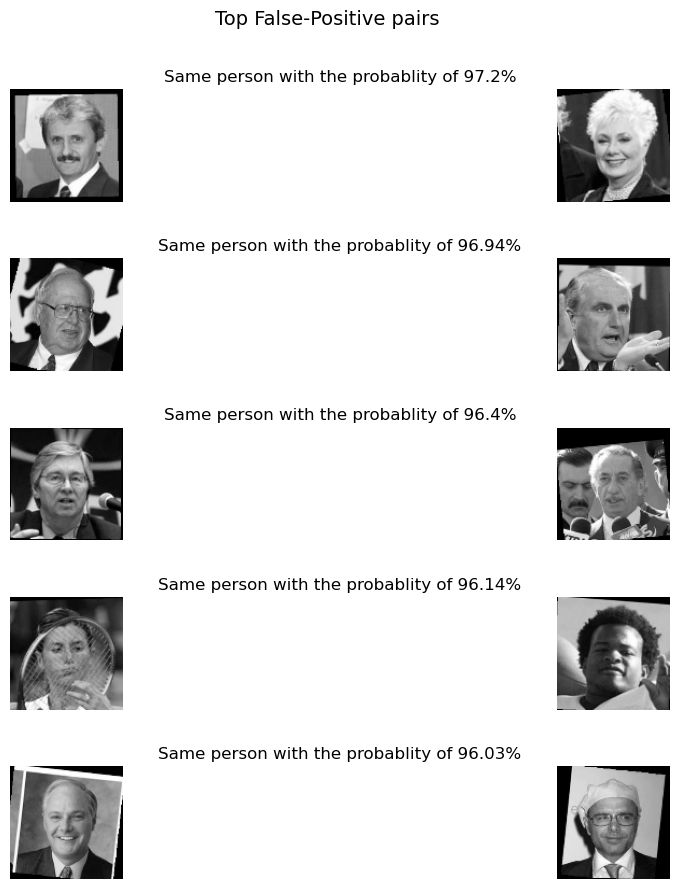

In [ ]:
results_visual_on_dataset(5, test_dataset, siamese, np_arr_is_match_test)